## Pipelines y modelos de Machine Learning

En este notebook vamos a ver cómo se pueden utilizar los pipelines de scikit-learn para encadenar varios pasos de preprocesamiento y modelado de datos.

Usaremos el dataset Adult, que contiene información sobre personas y su salario. El objetivo es predecir si una persona gana más o menos de 50k al año. En este ejercicio usaremos el dataset alojado en UCI Machine Learning Repository.

In [2]:
pip install xgboost

   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.8 MB 330.3 kB/s eta 0:05:02
   ---------------------------------------- 0.1/99.8 MB 585.1 kB/s eta 0:02:51
   ---------------------------------------- 0.2/99.8 MB 766.6 kB/s eta 0:02:10
   ---------------------------------------- 0.2/99.8 MB 1.0 MB/s eta 0:01:37
   ---------------------------------------- 0.4/99.8 MB 1.5 MB/s eta 0:01:09
   ---------------------------------------- 0.6/99.8 MB 1.8 MB/s eta 0:00:54
   ---------------------------------------- 1.0/99.8 MB 2.5 MB/s eta 0:00:39
    --------------------------------------- 1.5/99.8 MB 3.5 MB/s eta 0:00:29
    --------------------------------------- 2.1/99.8 MB 4.4 MB/s eta 0:00:23
   - -------------------------------------- 2.6/99.8 MB 5.1 MB/s eta 0:00:20
   - ---------

In [3]:
## Import xgboost

import xgboost as xgb

In [4]:
## instalar ucimlrepo
## pip install ucimlrepo
## pip install certifi

from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
adult = fetch_ucirepo(id=2) 
  
# data (as pandas dataframes) 
X = adult.data.features 
y = adult.data.targets 

In [5]:
import pandas as pd

adult=pd.DataFrame(X)
adult_y=pd.DataFrame(y)

adult['target']=adult_y

adult.head()

age         workclass  fnlwgt  education  education-num  \
0   39         State-gov   77516  Bachelors             13   
1   50  Self-emp-not-inc   83311  Bachelors             13   
2   38           Private  215646    HS-grad              9   
3   53           Private  234721       11th              7   
4   28           Private  338409  Bachelors             13   

       marital-status         occupation   relationship   race     sex  \
0       Never-married       Adm-clerical  Not-in-family  White    Male   
1  Married-civ-spouse    Exec-managerial        Husband  White    Male   
2            Divorced  Handlers-cleaners  Not-in-family  White    Male   
3  Married-civ-spouse  Handlers-cleaners        Husband  Black    Male   
4  Married-civ-spouse     Prof-specialty           Wife  Black  Female   

   capital-gain  capital-loss  hours-per-week native-country target  
0          2174             0              40  United-States  <=50K  
1             0             0              13  United-States  <=50K  
2             0             0              40  United-States  <=50K  
3             0             0              40  United-States  <=50K  
4             0             0              40           Cuba  <=50K

Este dataset contiene columnas de varios tipos, lo que nos permitirá ver cómo tratar diferentes tipos de datos en un pipeline.

Iniciamos con un tratamiento para las variables categoricas que tendrá dos partes:

1- Tratamiento de Nulos (usamos SimpleImputer)   
2- Codificación de Variables Categóricas (Usamos OneHotEncoder, OrdinalEncoder, TargetEncoder)


In [6]:
adult.describe(include='object')

workclass education      marital-status      occupation relationship  \
count      47879     48842               48842           47876        48842   
unique         9        16                   7              15            6   
top      Private   HS-grad  Married-civ-spouse  Prof-specialty      Husband   
freq       33906     15784               22379            6172        19716   

         race    sex native-country target  
count   48842  48842          48568  48842  
unique      5      2             42      4  
top     White   Male  United-States  <=50K  
freq    41762  32650          43832  24720

In [7]:
#adult.drop('target',axis=1,inplace=True)

adult.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       47879 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education-num   48842 non-null  int64 
 5   marital-status  48842 non-null  object
 6   occupation      47876 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital-gain    48842 non-null  int64 
 11  capital-loss    48842 non-null  int64 
 12  hours-per-week  48842 non-null  int64 
 13  native-country  48568 non-null  object
 14  target          48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


In [8]:
## Diferencias entre education y education-num

adult['education'].value_counts()

education
HS-grad         15784
Some-college    10878
Bachelors        8025
Masters          2657
Assoc-voc        2061
11th             1812
Assoc-acdm       1601
10th             1389
7th-8th           955
Prof-school       834
9th               756
12th              657
Doctorate         594
5th-6th           509
1st-4th           247
Preschool          83
Name: count, dtype: int64

In [9]:
adult[['education','education-num']].value_counts()

education     education-num
HS-grad       9                15784
Some-college  10               10878
Bachelors     13                8025
Masters       14                2657
Assoc-voc     11                2061
11th          7                 1812
Assoc-acdm    12                1601
10th          6                 1389
7th-8th       4                  955
Prof-school   15                 834
9th           5                  756
12th          8                  657
Doctorate     16                 594
5th-6th       3                  509
1st-4th       2                  247
Preschool     1                   83
Name: count, dtype: int64

<Axes: >

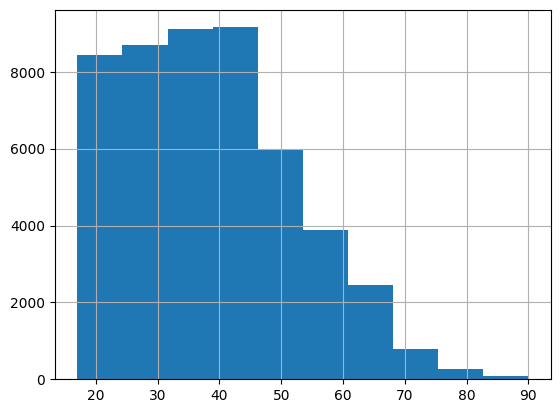

In [10]:
adult['age'].hist()

In [11]:
## Hacemos un boxplot
import matplotlib.pyplot as plt

adult_temp=adult.copy()
print(adult_temp['capital-gain'].quantile(0.90))
adult_temp=adult_temp[adult_temp['capital-gain']<=adult_temp['capital-gain'].quantile(0.90)]
adult_temp

0.0


age         workclass  fnlwgt  education  education-num  \
1       50  Self-emp-not-inc   83311  Bachelors             13   
2       38           Private  215646    HS-grad              9   
3       53           Private  234721       11th              7   
4       28           Private  338409  Bachelors             13   
5       37           Private  284582    Masters             14   
...    ...               ...     ...        ...            ...   
48836   33           Private  245211  Bachelors             13   
48837   39           Private  215419  Bachelors             13   
48838   64               NaN  321403    HS-grad              9   
48839   38           Private  374983  Bachelors             13   
48841   35      Self-emp-inc  182148  Bachelors             13   

           marital-status         occupation    relationship   race     sex  \
1      Married-civ-spouse    Exec-managerial         Husband  White    Male   
2                Divorced  Handlers-cleaners   Not-in-family  White    Male   
3      Married-civ-spouse  Handlers-cleaners         Husband  Black    Male   
4      Married-civ-spouse     Prof-specialty            Wife  Black  Female   
5      Married-civ-spouse    Exec-managerial            Wife  White  Female   
...                   ...                ...             ...    ...     ...   
48836       Never-married     Prof-specialty       Own-child  White    Male   
48837            Divorced     Prof-specialty   Not-in-family  White  Female   
48838             Widowed                NaN  Other-relative  Black    Male   
48839  Married-civ-spouse     Prof-specialty         Husband  White    Male   
48841  Married-civ-spouse    Exec-managerial         Husband  White    Male   

       capital-gain  capital-loss  hours-per-week native-country  target  
1                 0             0              13  United-States   <=50K  
2                 0             0              40  United-States   <=50K  
3                 0             0              40  United-States   <=50K  
4                 0             0              40           Cuba   <=50K  
5                 0             0              40  United-States   <=50K  
...             ...           ...             ...            ...     ...  
48836             0             0              40  United-States  <=50K.  
48837             0             0              36  United-States  <=50K.  
48838             0             0              40  United-States  <=50K.  
48839             0             0              50  United-States  <=50K.  
48841             0             0              60  United-States   >50K.  

[44807 rows x 15 columns]

<Axes: >

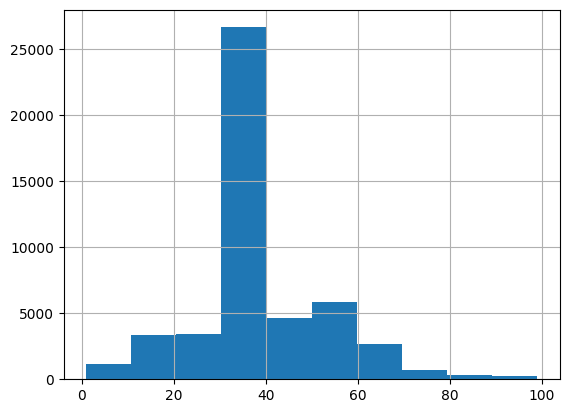

In [12]:
## Hacemos un boxplot de hours-per-week

adult['hours-per-week'].hist()

In [13]:
adult['occupation'].value_counts()

occupation
Prof-specialty       6172
Craft-repair         6112
Exec-managerial      6086
Adm-clerical         5611
Sales                5504
Other-service        4923
Machine-op-inspct    3022
Transport-moving     2355
Handlers-cleaners    2072
?                    1843
Farming-fishing      1490
Tech-support         1446
Protective-serv       983
Priv-house-serv       242
Armed-Forces           15
Name: count, dtype: int64

In [14]:
adult_y['income']=adult_y['income'].str.replace(".","")
## LABEL ENCODER
from sklearn.preprocessing import LabelEncoder

le=LabelEncoder()

adult_y['income']=le.fit_transform(adult_y['income'])

adult_y['income'].value_counts()

income
0    37155
1    11687
Name: count, dtype: int64

## NULOS

Para tratar los nulos, usaremos SimpleImputer. Este transformador nos permite reemplazar los valores nulos por un valor fijo o por la media, mediana, moda, etc. de la columna.


In [15]:
## Hacemos un SimpleImputer para las variables categóricas y otro para las numéricas

## Llamamos el objeto
from sklearn.impute import SimpleImputer

## Instanciamos el objeto
imp_cat = SimpleImputer(strategy='constant',fill_value='?')
imp_num = SimpleImputer(strategy='mean')

## Hacemos un fit_transform para las variables categóricas

adult_cat=imp_cat.fit_transform(adult.select_dtypes(include='object'))
adult_cat=pd.DataFrame(adult_cat,columns=adult.select_dtypes(include='object').columns)

adult_cat['occupation'].value_counts()

occupation
Prof-specialty       6172
Craft-repair         6112
Exec-managerial      6086
Adm-clerical         5611
Sales                5504
Other-service        4923
Machine-op-inspct    3022
?                    2809
Transport-moving     2355
Handlers-cleaners    2072
Farming-fishing      1490
Tech-support         1446
Protective-serv       983
Priv-house-serv       242
Armed-Forces           15
Name: count, dtype: int64

In [16]:
adult['target']=adult['target'].str.replace(".","")

## ENCODERS

Los encoders en scikit-learn son objetos que permiten transformar variables categóricas en numéricas. Existen varios tipos de encoders, cada uno con sus propias características:

- OneHotEncoder: Codifica variables categóricas en variables binarias. Crea una columna por cada categoría distinta en la variable original, y asigna un 1 en la columna correspondiente a la categoría de cada fila.

- OrdinalEncoder: Codifica variables categóricas en variables numéricas enteras. Asigna un número entero a cada categoría distinta en la variable original.

- TargetEncoder: Codifica variables categóricas en variables numéricas, asignando a cada categoría el promedio de la variable objetivo para esa categoría.


In [17]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, TargetEncoder
from sklearn.compose import ColumnTransformer

### Trabajaremos de acuerdo al plan de preprocesamiento
### OHE -> ['workclass', 'marital-status', 'occupation', 'relationship','race','sex']
### ORD -> ['education']
### TE -> ['native-country']

OHE_COLS=['workclass', 'marital-status', 'occupation', 'relationship','race','sex']
ORD_COLS=['education']
TE_COLS=['native-country']

## Instanciamos los objetos
ohe=OneHotEncoder()
ord=OrdinalEncoder()
te=TargetEncoder()

## Hacemos el fit de los objetos con los datos

ohe.fit(adult[OHE_COLS])
ord.fit(adult[ORD_COLS],adult['education-num'])
te.fit(adult[TE_COLS],adult_y)

## Hacemos la transformación de los datos

ohe_data=ohe.transform(adult[OHE_COLS]).toarray()
ord_data=ord.transform(adult[ORD_COLS])
te_data=te.transform(adult[TE_COLS])

## Hacemos un merge de los datos

adult_data_cat=pd.concat([pd.DataFrame(ohe_data),pd.DataFrame(ord_data),pd.DataFrame(te_data)],axis=1)

adult_data_cat.head()

c:\Users\cizai\miniconda3\envs\m3cidru12024\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0    1    2    3    4    5    6    7    8    9   ...   38   39   40   41  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  1.0   
4  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  ...  1.0  0.0  0.0  1.0   

    42   43   44   45    0         0   
0  0.0  1.0  0.0  1.0   9.0  0.243977  
1  0.0  1.0  0.0  1.0   9.0  0.243977  
2  0.0  1.0  0.0  1.0  11.0  0.243977  
3  0.0  0.0  0.0  1.0   1.0  0.243977  
4  0.0  0.0  1.0  0.0   9.0  0.246325  

[5 rows x 48 columns]

In [18]:
### Hacemos un fit_transform de las variables numéricas

from sklearn.preprocessing import StandardScaler, MinMaxScaler

## HAcemos las estandarización de las variables numéricas de la siguiente forma:
## StandardScaler -> ['capital-gain', 'capital-loss']
## MinMaxScaler -> ['age','hours-per-week']

SS_COLS=['capital-gain', 'capital-loss']
MM_COLS=['age','hours-per-week']

## Instanciamos los objetos
ss=StandardScaler()
mm=MinMaxScaler()

## Hacemos el fit de los objetos con los datos

ss.fit(adult[SS_COLS])      
mm.fit(adult[MM_COLS])

## Hacemos la transformación de los datos

ss_data=ss.transform(adult[SS_COLS])
mm_data=mm.transform(adult[MM_COLS])

## Hacemos un merge de los datos

adult_data_num=pd.concat([pd.DataFrame(ss_data),pd.DataFrame(mm_data)],axis=1)
adult_data_num.columns=['capital-gain', 'capital-loss','age','hours-per-week']

adult_data_num.head()

capital-gain  capital-loss       age  hours-per-week
0      0.146932     -0.217127  0.301370        0.397959
1     -0.144804     -0.217127  0.452055        0.122449
2     -0.144804     -0.217127  0.287671        0.397959
3     -0.144804     -0.217127  0.493151        0.397959
4     -0.144804     -0.217127  0.150685        0.397959

## CREACION DE PIPELINES

Haremos un pipeline para el preprocesamiento de todos estos datos usando lo que ya definimos.

In [20]:
### Los objetos que definimos son
## imp_cat -> Imputer para las variables categóricas
## imp_num -> Imputer para las variables numéricas
## ohe -> OneHotEncoder para las variables categóricas
## ord -> OrdinalEncoder para la variable 'education'
## te -> TargetEncoder para la variable 'native-country'
## ss -> StandardScaler para las variables ['capital-gain', 'capital-loss']
## mm -> MinMaxScaler para las variables ['age','hours-per-week']

## Las columnas procesadas segun los encoder son
## OHE_COLS=['workclass', 'marital-status', 'occupation', 'relationship','race','sex']
## ORD_COLS=['education']
## TE_COLS=['native-country']

## SS_COLS=['capital-gain', 'capital-loss']
## MM_COLS=['age','hours-per-week']

## Con esos objetos y usando ColumnTransformer y Pipeline hacemos un artefacto para el preprocesamiento de los datos



## PIPELINE y COLUMN TRANSFORMER
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, TargetEncoder, StandardScaler, MinMaxScaler, LabelEncoder

### Los objetos que definimos son



## Instanciamos los objetos
imp_cat = SimpleImputer(strategy='constant',fill_value='?')
imp_num = SimpleImputer(strategy='mean')
ohe=OneHotEncoder(sparse_output=False)
ord=OrdinalEncoder()
te=TargetEncoder()
ss=StandardScaler()
mm=MinMaxScaler()

cat_pipe_ohe=Pipeline(steps=[('imputer',imp_cat),
                             ('encoder',ohe)])

cat_pipe_ord=Pipeline(steps=[('imputer',imp_cat),
                                ('encoder',ord)])

cat_pipe_te=Pipeline(steps=[('imputer',imp_cat),
                                ('encoder',te)])

num_pipe_ss=Pipeline(steps=[('imputer',imp_num),
                            ('scaler',ss)])

num_pipe_mm=Pipeline(steps=[('imputer',imp_num),
                            ('scaler',mm)])

## Hacemos un ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('cat_ohe', cat_pipe_ohe, OHE_COLS),
        ('cat_ord', cat_pipe_ord, ORD_COLS),
        ('cat_te', cat_pipe_te, TE_COLS),
        ('num_ss', num_pipe_ss, SS_COLS),
        ('num_mm', num_pipe_mm, MM_COLS)
    ])





In [21]:
preprocessor

ColumnTransformer(transformers=[('cat_ohe',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='?',
                                                                strategy='constant')),
                                                 ('encoder',
                                                  OneHotEncoder(sparse_output=False))]),
                                 ['workclass', 'marital-status', 'occupation',
                                  'relationship', 'race', 'sex']),
                                ('cat_ord',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='?',
                                                                strategy='constant')),
                                                 ('encoder',
                                                  Ordinal...
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='?',
                                                                strategy='constant')),
                                                 ('encoder', TargetEncoder())]),
                                 ['native-country']),
                                ('num_ss',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['capital-gain', 'capital-loss']),
                                ('num_mm',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', MinMaxScaler())]),
                                 ['age', 'hours-per-week'])])

In [22]:
## Data procesada
pd.set_option('display.max_columns', None)

data_processed_arr=preprocessor.fit_transform(adult[OHE_COLS+ORD_COLS+TE_COLS+SS_COLS+MM_COLS],adult_y)

data_processed=pd.DataFrame(data_processed_arr)

data_processed.columns=preprocessor.transformers_[0][1]['encoder'].get_feature_names_out().tolist()+\
                        ORD_COLS+TE_COLS+SS_COLS+MM_COLS

data_processed.head()

c:\Users\cizai\miniconda3\envs\m3cidru12024\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


x0_?  x0_Federal-gov  x0_Local-gov  x0_Never-worked  x0_Private  \
0   0.0             0.0           0.0              0.0         0.0   
1   0.0             0.0           0.0              0.0         0.0   
2   0.0             0.0           0.0              0.0         1.0   
3   0.0             0.0           0.0              0.0         1.0   
4   0.0             0.0           0.0              0.0         1.0   

   x0_Self-emp-inc  x0_Self-emp-not-inc  x0_State-gov  x0_Without-pay  \
0              0.0                  0.0           1.0             0.0   
1              0.0                  1.0           0.0             0.0   
2              0.0                  0.0           0.0             0.0   
3              0.0                  0.0           0.0             0.0   
4              0.0                  0.0           0.0             0.0   

   x1_Divorced  x1_Married-AF-spouse  x1_Married-civ-spouse  \
0          0.0                   0.0                    0.0   
1          0.0                   0.0                    1.0   
2          1.0                   0.0                    0.0   
3          0.0                   0.0                    1.0   
4          0.0                   0.0                    1.0   

   x1_Married-spouse-absent  x1_Never-married  x1_Separated  x1_Widowed  x2_?  \
0                       0.0               1.0           0.0         0.0   0.0   
1                       0.0               0.0           0.0         0.0   0.0   
2                       0.0               0.0           0.0         0.0   0.0   
3                       0.0               0.0           0.0         0.0   0.0   
4                       0.0               0.0           0.0         0.0   0.0   

   x2_Adm-clerical  x2_Armed-Forces  x2_Craft-repair  x2_Exec-managerial  \
0              1.0              0.0              0.0                 0.0   
1              0.0              0.0              0.0                 1.0   
2              0.0              0.0              0.0                 0.0   
3              0.0              0.0              0.0                 0.0   
4              0.0              0.0              0.0                 0.0   

   x2_Farming-fishing  x2_Handlers-cleaners  x2_Machine-op-inspct  \
0                 0.0                   0.0                   0.0   
1                 0.0                   0.0                   0.0   
2                 0.0                   1.0                   0.0   
3                 0.0                   1.0                   0.0   
4                 0.0                   0.0                   0.0   

   x2_Other-service  x2_Priv-house-serv  x2_Prof-specialty  \
0               0.0                 0.0                0.0   
1               0.0                 0.0                0.0   
2               0.0                 0.0                0.0   
3               0.0                 0.0                0.0   
4               0.0                 0.0                1.0   

   x2_Protective-serv  x2_Sales  x2_Tech-support  x2_Transport-moving  \
0                 0.0       0.0              0.0                  0.0   
1                 0.0       0.0              0.0                  0.0   
2                 0.0       0.0              0.0                  0.0   
3                 0.0       0.0              0.0                  0.0   
4                 0.0       0.0              0.0                  0.0   

   x3_Husband  x3_Not-in-family  x3_Other-relative  x3_Own-child  \
0         0.0               1.0                0.0           0.0   
1         1.0               0.0                0.0           0.0   
2         0.0               1.0                0.0           0.0   
3         1.0               0.0                0.0           0.0   
4         0.0               0.0                0.0           0.0   

   x3_Unmarried  x3_Wife  x4_Amer-Indian-Eskimo  x4_Asian-Pac-Islander  \
0           0.0      0.0                    0.0                    0.0   
1           0.0      0.0            

## Mejor xgboost

Para el modelo usaremos xgboost, que es un algoritmo de boosting muy popular y efectivo.

## Parametros de xgboost

Usaremos GridSearchCV para encontrar los mejores hiperparámetros para nuestro modelo.

- n_thread: número de hilos a utilizar para entrenar el modelo
- eta: tasa de aprendizaje
- max_depth: profundidad máxima de los árboles
- n_estimators: número de árboles a utilizar
- subsample: proporción de muestras a utilizar para entrenar cada árbol
- num_parallel_tree: número de árboles a entrenar en paralelo


In [27]:
## Definimos la lista de hiperparametros para el modelo xgboost

hiperparametros_xgb = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 4, 5, 6, 7, 8],
    'learning_rate': [0.01, 0.05, 0.1,0.3,],
    #'subsample': [0.5, 0.7, 0.9, 1],
    #'reg_lambda': [0, 0.5, 1],
    #'gamma': [0, 0.5, 1],
    #'min_child_weight': [1, 5, 10, 20, 50],
    'nthread': [4],
}

Definir el procesos de clasificación de un árbol de decisión con el dataset Adult.

In [28]:
### Definimos el modelo de xgboost


from sklearn.model_selection import GridSearchCV

modelo_xgb=xgb.XGBClassifier()
modelo_xgb_grid = GridSearchCV(modelo_xgb, hiperparametros_xgb, cv=3, n_jobs=-1, verbose=3)

### Hacemos un split de los datos

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_processed, adult_y, test_size=0.3, random_state=42)


modelo_xgb_grid


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.3],
                         'max_depth': [3, 4, 5, 6, 7, 8],
                         'n_estimators': [100, 200, 300, 400, 500],
                         'nthread': [4]},
             verbose=3)

In [29]:
### Hacemos un fit del modelo

modelo_xgb_grid.fit(X_train,y_train)

### Hacemos un predict

y_pred=modelo_xgb_grid.predict(X_test)

from sklearn.metrics import classification_report

print(classification_report(y_test,y_pred))

Fitting 3 folds for each of 120 candidates, totalling 360 fits
              precision    recall  f1-score   support

           0       0.89      0.95      0.92     11109
           1       0.80      0.64      0.71      3544

    accuracy                           0.87     14653
   macro avg       0.84      0.79      0.81     14653
weighted avg       0.87      0.87      0.87     14653



In [30]:
### El mejor modelo es:

modelo_xgb_grid.best_params_

{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 300, 'nthread': 4}

## Acoplamos preprocessing y modelado en un solo pipeline

Para finalizar, vamos a acoplar el preprocesamiento y el modelado en un solo pipeline. De esta forma, podremos entrenar y evaluar el modelo con un solo paso.

In [ ]:
## Importamos el dataset de adult

from ucimlrepo import fetch_ucirepo

adult = fetch_ucirepo(id=2)

X = adult.data.features
y = adult.data.targets['income'].str.replace(".","")
y=y.replace({'<=50K':0,'>50K':1})
X

In [ ]:
y

In [ ]:
### Desde el principio

# importar librerias

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer    
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, TargetEncoder, StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

## Definimos las columnas

OHE_COLS=['workclass', 'marital-status', 'occupation', 'relationship','race','sex']
ORD_COLS=['education']
TE_COLS=['native-country']
SS_COLS=['capital-gain', 'capital-loss']
MM_COLS=['age','hours-per-week']

## Instanciamos los objetos
imp_cat = SimpleImputer(strategy='constant',fill_value='?')
imp_num = SimpleImputer(strategy='mean')
ohe=OneHotEncoder(sparse_output=False)
ord=OrdinalEncoder()
te=TargetEncoder()
ss=StandardScaler()
mm=MinMaxScaler()

cat_pipe_ohe=Pipeline(steps=[('imputer',imp_cat),
                                ('encoder',ohe)])

cat_pipe_ord=Pipeline(steps=[('imputer',imp_cat),
                                ('encoder',ord)])

cat_pipe_te=Pipeline(steps=[('imputer',imp_cat),
                                ('encoder',te)])

num_pipe_ss=Pipeline(steps=[('imputer',imp_num),
                            ('scaler',ss)])

num_pipe_mm=Pipeline(steps=[('imputer',imp_num),
                            ('scaler',mm)])

## Hacemos un ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('cat_ohe', cat_pipe_ohe, OHE_COLS),
        ('cat_ord', cat_pipe_ord, ORD_COLS),
        ('cat_te', cat_pipe_te, TE_COLS),
        ('num_ss', num_pipe_ss, SS_COLS),
        ('num_mm', num_pipe_mm, MM_COLS)
    ])

## Definimos la lista de hiperparametros de los árboles de decision

hiperparametros_arbol={'criterion': ['gini', 'entropy'],
                          'max_depth': [ 5, 10,  20,  30],
                            'min_samples_split': [10,20,30,40],
                            'min_samples_leaf': [5,10,20,30]}

### Definimos el modelo de árbol de decisión

modelo_arbol=DecisionTreeClassifier()

modelo_arbol_grid=GridSearchCV(modelo_arbol,hiperparametros_arbol,cv=5)

## Pipeline

pipe=Pipeline(steps=[('preprocessor',preprocessor),
                        ('modelo',modelo_arbol_grid)])

pipe

In [ ]:
X=X[OHE_COLS+ORD_COLS+TE_COLS+SS_COLS+MM_COLS]
X

In [ ]:
y

In [ ]:
### Hacemos un split de los datos
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

## Hacemos un fit del modelo
pipe.fit(X_train,y_train)

In [ ]:
### Evaluamos el modelo

y_pred=pipe.predict(X_test)

from sklearn.metrics import classification_report

print(classification_report(y_test,y_pred))

In [ ]:
## Mejor modelo

pipe.named_steps['modelo'].best_params_


In [ ]:
## Guardamos el pipeline usando joblib

import joblib

joblib.dump(pipe,'modelo_arbol.gz')

In [ ]:
### Desde el principio pero con Random Forest

# importar librerias

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer    
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, TargetEncoder, StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


## Definimos las columnas

OHE_COLS=['workclass', 'marital-status', 'occupation', 'relationship','race','sex']
ORD_COLS=['education']
TE_COLS=['native-country']
SS_COLS=['capital-gain', 'capital-loss']
MM_COLS=['age','hours-per-week']

## Instanciamos los objetos
imp_cat = SimpleImputer(strategy='constant',fill_value='?')
imp_num = SimpleImputer(strategy='mean')
ohe=OneHotEncoder(sparse_output=False)
ord=OrdinalEncoder()
te=TargetEncoder()
ss=StandardScaler()
mm=MinMaxScaler()

cat_pipe_ohe=Pipeline(steps=[('imputer',imp_cat),
                                ('encoder',ohe)])

cat_pipe_ord=Pipeline(steps=[('imputer',imp_cat),
                                ('encoder',ord)])

cat_pipe_te=Pipeline(steps=[('imputer',imp_cat),
                                ('encoder',te)])

num_pipe_ss=Pipeline(steps=[('imputer',imp_num),
                            ('scaler',ss)])

num_pipe_mm=Pipeline(steps=[('imputer',imp_num),
                            ('scaler',mm)])

## Hacemos un ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('cat_ohe', cat_pipe_ohe, OHE_COLS),
        ('cat_ord', cat_pipe_ord, ORD_COLS),
        ('cat_te', cat_pipe_te, TE_COLS),
        ('num_ss', num_pipe_ss, SS_COLS),
        ('num_mm', num_pipe_mm, MM_COLS)
    ])

## Definimos la lista de hiperparametros de random forest

hiperparametros_rf={'n_estimators': [100,200,300],
                    'criterion': ['gini', 'entropy'],
                    'max_depth': [ 5, 10,  20,  30],
                    'min_samples_split': [10,20,30,40],
                    'min_samples_leaf': [5,10,20,30]}

### Definimos el modelo de random forest

modelo_rf=RandomForestClassifier()

modelo_rf_grid=GridSearchCV(modelo_rf,hiperparametros_rf,cv=5)

## Pipeline

pipe=Pipeline(steps=[('preprocessor',preprocessor),
                        ('modelo',modelo_rf_grid)])

pipe

In [ ]:
pipe.fit(X_train,y_train)

### Evaluamos el modelo

y_pred=pipe.predict(X_test)

from sklearn.metrics import classification_report

print(classification_report(y_test,y_pred))

In [ ]:
### Mejor modelo

pipe.named_steps['modelo'].best_params_
